In [1]:
import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr
import cmocean.cm as cmocean
import glob
import matplotlib.path as mpath
import matplotlib.colors as col
import pandas as pd
import scipy.stats as stats
from tqdm import tqdm
import logging
import matplotlib.cm as cm


logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

In [2]:
client = Client(n_workers=28)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 28
Total threads: 28,Total memory: 251.20 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37077,Workers: 28
Dashboard: http://127.0.0.1:8787/status,Total threads: 28
Started: Just now,Total memory: 251.20 GiB
Comm: tcp://127.0.0.1:44977,Total threads: 1
Dashboard: http://127.0.0.1:34065/status,Memory: 8.97 GiB
Nanny: tcp://127.0.0.1:41771,


In [3]:
# Load the along-slope velocity field
u_along = xr.open_mfdataset('/g/data/v45/wf4500/ASC_project_files/Binned_ASC_speed/OM2_IAF/Binned_Antarctic_slope_contour_1km_velocities*')
# Load CSHT field
CSHT_along = xr.open_mfdataset(\
    '/g/data/v45/wf4500/ASC_project_files/Cross_slope_heat_transport/OM2_IAF/daily_z/*')

0.3.0


In [4]:
exp = '01deg_jra55v140_iaf_cycle3'
start_time= '1958-01-01'
end_time= '2018-12-31'
lat_range = slice(-90,-59)
isobath_depth = 1000

session = cc.database.create_session()

In [5]:
# importing area for averaging
#tarea = cc.querying.getvar(exp, 'area_t', session,n=1).sel(yt_ocean=lat_range)
dzt= cc.querying.getvar(exp, 'dzt', session,n=1,start_time=start_time,end_time=end_time).mean('time').sel(yt_ocean=lat_range)

0.3.0


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.10/lib/python3.10/site-packages/xarray/core/dataset.py:282: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(


In [6]:
#coordinates for extraction of data along contour
lon_bin_midpoints = CSHT_along.isel(st_ocean=0,time=0).lon_bin_midpoints.drop(('time','st_ocean'))
lat_bin_midpoints = CSHT_along.isel(st_ocean=0,time=0).lat_bin_midpoints.drop(('time','st_ocean'))
lon_along_contour = CSHT_along.isel(st_ocean=0,time=0).lon_along_contour.drop(('time','st_ocean'))
lat_along_contour = CSHT_along.isel(st_ocean=0,time=0).lat_along_contour.drop(('time','st_ocean'))

# Extracting area along contour
tarea_ub = tarea.sel(yt_ocean=lat_along_contour,\
                     xt_ocean=lon_along_contour, method='nearest').compute()
tarea_b = tarea.sel(yt_ocean=lat_bin_midpoints,\
                    xt_ocean=lon_bin_midpoints, method='nearest').compute() 
# #the values on tarea_b are not realistic as the average of the unbined area in
# # the 3 degrees bin is likely no the area of the cel in the mid bin point.
# # But we are extracing anyways, to have an xarray with the coordinates we want. 
# # Below we actualy calculate the mean area, and will replace the resulting np.array
# #  in the xarray above.


dzt_ub=dzt.sel(yt_ocean=lat_along_contour,\
                     xt_ocean=lon_along_contour, method='nearest').compute()
dzt_b=dzt.sel(yt_ocean=lat_bin_midpoints,\
                     xt_ocean=lon_bin_midpoints, method='nearest').compute()
# #the values on dzt_b are not realistic as the average of the unbined area in
# # the 3 degrees bin is likely no the area of the cel in the mid bin point.
# # But we are extracing anyways, to have an xarray with the coordinates we want. 
# # Below we actualy calculate the mean area, and will replace the resulting np.array
# #  in the xarray above.
dzt_mean=dzt_ub.weighted(tarea_ub).mean('contour_index')

NameError: name 'tarea' is not defined

In [ ]:
#binning the model area
# convert to longitude coordinate and average into 3 degree longitude bins:
# in degrees:
bin_width = 3
bin_spacing = 0.25
lon_west = -280
lon_east = 80

# new coordinate and midpoints of longitude bins:
full_lon_coord = np.arange(lon_west,lon_east+bin_spacing,bin_spacing)
lon_bin_midpoints0 = np.arange(lon_west+bin_width/2,lon_east-bin_width/2,bin_spacing)
n_bin_edges = len(full_lon_coord)
lon_along_contour0=np.array(lon_along_contour)
lat_along_contour0=np.array(lat_along_contour)
tarea_ub0=np.array(tarea_ub)
# sum into longitude bins:
# need to be very careful of loops, we can't just mask over longitude values, but instead pick indices 
# on the isobath contour and sum continously along contour between defined indices.
# (i.e. lon_along_contour is not monotonic)
# find points on contour to define edges of longitude bins:
bin_edge_indices = np.zeros(n_bin_edges)
for lon_bin in range(n_bin_edges-1):
	# find first isobath point that has the right longitude:
	first_point = np.where(lon_along_contour0>=full_lon_coord[lon_bin])[0][0]
	# then find all other isobath points with the same longitude as that first point:
	same_lon_points = np.where(lon_along_contour0==lon_along_contour0[first_point])[0]
	# we want the most southerly of these points on the same longitude line:
	bin_edge_indices[lon_bin] = same_lon_points[np.argmin(lat_along_contour0[same_lon_points])]
	
	# define east/west edges:
	bin_edge_indices = bin_edge_indices.astype(int)
	bin_edge_indices_west = bin_edge_indices[:-int(bin_width/bin_spacing)-1]
	bin_edge_indices_east = bin_edge_indices[int(bin_width/bin_spacing):-1]
	n_bins = len(bin_edge_indices_west)
	
	# sum heat transport from isobath coord into new longitude coord:
	tarea_b0 = np.zeros([n_bins])
	for lon_bin in range(n_bins):
		T0 = tarea_ub0[bin_edge_indices_west[lon_bin]:bin_edge_indices_east[lon_bin]]
		tarea_b0[lon_bin] = np.nanmean(T0)
	

tarea_b.values=tarea_b0

In [ ]:
#mean heat transport
CSHTint = ((CSHT_along.binned_cross_slope_heat_trans + CSHT_along.zonal_convergence)*0.08).sum('st_ocean').sum('lon_bin_midpoints').compute()
Ualongmean= u_along.u_along_contour_binned.weighted(dzt_mean.fillna(0)).mean('st_ocean').weighted(tarea_b).mean('lon_bin_midpoints').compute()

In [ ]:
# calculating a linear regression
from scipy.stats import linregress
slope, intercept, r, p, se = linregress(Ualongmean,CSHTint/1e12)

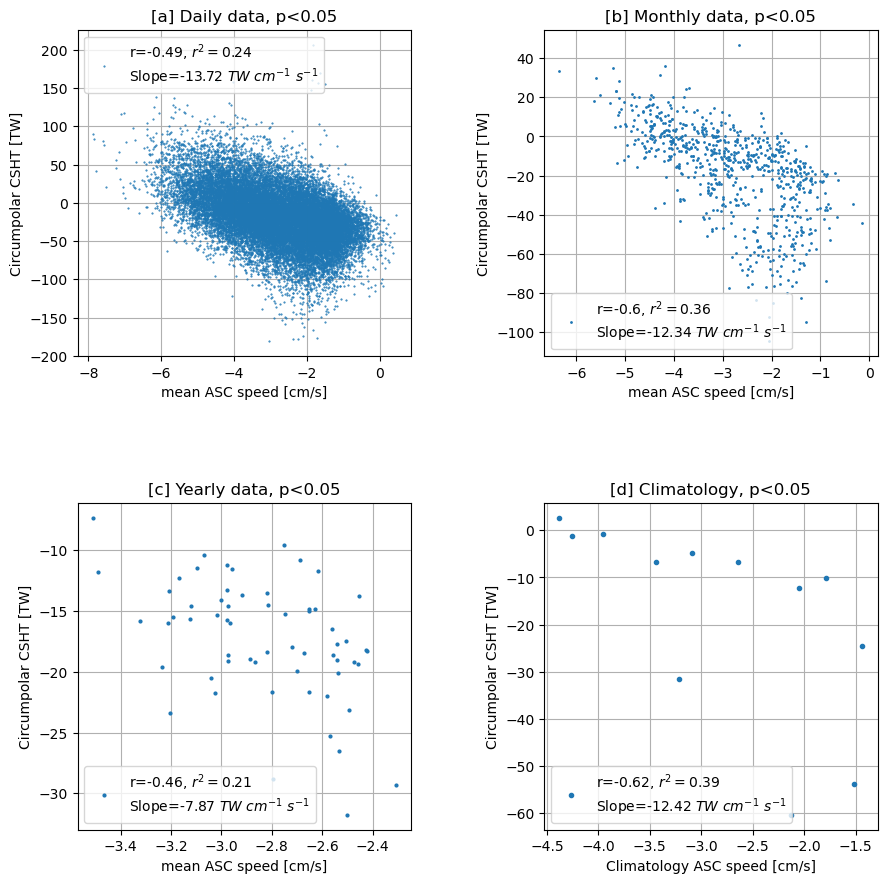

In [ ]:
plt.figure(figsize=(10, 10))
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.45)

#for panan01
plt.subplot(2,2,1)

plt.plot(Ualongmean*100,CSHTint/1e12,'.',markersize=1,\
         label=r"r=" + str(round(r,2)) + ", $r^2=$" + str(round(r**2,2)) +\
            "\nSlope=" + str(round(slope*1e-2,2)) +  " $TW\ cm^{-1}\ s^{-1}$")
plt.xlabel('mean ASC speed [cm/s]'); plt.ylabel('Circumpolar CSHT [TW]')
plt.grid()
plt.title('[a] Daily data, p<0.05')
plt.legend()


plt.subplot(2,2,2)
slopem, interceptm, rm, pm, sem = linregress(Ualongmean.resample(time="1MS").mean('time'),(CSHTint/1e12).resample(time="1MS").mean('time'))

plt.plot((Ualongmean*100).resample(time="1MS").mean('time'),\
         CSHTint.resample(time="1MS").mean('time')/1e12,'.',markersize=2,\
         label=r"r=" + str(round(rm,2)) + ", $r^2=$" + str(round(rm**2,2)) +\
            "\nSlope=" + str(round(slopem*1e-2,2)) +  " $TW\ cm^{-1}\ s^{-1}$")
plt.xlabel('mean ASC speed [cm/s]'); plt.ylabel('Circumpolar CSHT [TW]')
plt.grid()
plt.title('[b] Monthly data, p<0.05')
plt.legend()


plt.subplot(2,2,3)

slopey, intercepty, ry, py, sey = linregress(Ualongmean.resample(time="1Y").mean('time'),(CSHTint/1e12).resample(time="1Y").mean('time'))

plt.plot((Ualongmean*100).resample(time="1Y").mean('time'),\
         CSHTint.resample(time="1y").mean('time')/1e12,'.',markersize=4,\
         label=r"r=" + str(round(ry,2)) + ", $r^2=$" + str(round(ry**2,2)) +\
            "\nSlope=" + str(round(slopey*1e-2,2)) +  " $TW\ cm^{-1}\ s^{-1}$")
plt.xlabel('mean ASC speed [cm/s]'); plt.ylabel('Circumpolar CSHT [TW]')
plt.grid()
plt.title('[c] Yearly data, p<0.05')
plt.legend()


plt.subplot(2,2,4)

slopec, interceptc, rc, pc, sec = linregress(Ualongmean.groupby('time.month').mean('time'),(CSHTint/1e12).groupby('time.month').mean('time'))

plt.plot((Ualongmean*100).groupby('time.month').mean('time'),\
         CSHTint.groupby('time.month').mean('time')/1e12,'.',markersize=6,\
         label=r"r=" + str(round(rc,2)) + ", $r^2=$" + str(round(rc**2,2)) +\
            "\nSlope=" + str(round(slopec*1e-2,2)) +  " $TW\ cm^{-1}\ s^{-1}$")
plt.xlabel('Climatology ASC speed [cm/s]'); plt.ylabel('Circumpolar CSHT [TW]')
plt.grid()
plt.title('[d] Climatology, p<0.05')
plt.legend()

-The mean analysis seem to show that indeed the weaker the ASC speed, the stronger seem to be the Southward CSHT.  It shows that a decrease of 1 cm/s in mean ASC causes an increase in CSHT of ~ 14 TW. 

-However the determination coefficient shows that this accounts for only 24% of the total variability in mean CSHT in the model. So the model seem to suggest that the ASC speed have only a small control in the CSHT. If we analyze different timescales, it seems that ASC speed explains more of the data variability using monthly data, and a lot of it can be due to the climatological oscilations in ASC and CSHT (d).

-There could be several reasons here. First, circumpolarly averaging the ASC is not necessairily useful, as ASC changes its se peed direction and profile along the Antarctic Shelf. Also, the heat might be ablt to cross the isobath only in a few ASC regimes. So it is importnat to see, how does this correlation changes in each regime.

## Correlation by regime

We have used Machine learning to define the ASC regime, according to the dynamics proposed by Huneke et al (2020). LEt's separate these regimes and see how the correlation changes it.

In [ ]:
#We are using here a monthly mask.
cluster_mask=xr.open_dataset("/g/data/v45/txs156/ASC_classification/clustering_mask.nc")
cluster_maskdaily=cluster_mask.interp(time=CSHTint.time)


I interpolated the masks into the daily field to do this calculation.  To make sure the interpolation made sense I plotted the non-interpolated and interpoalted data for regime=0 to see if it was different, and it seemed quite similar, so I moved forward

In [ ]:
################# CSHT per regime

#for surface intensified regimes, isel 0
CSHTint_surface =( ( (CSHT_along.binned_cross_slope_heat_trans + CSHT_along.zonal_convergence)*0.08 )\
    *cluster_maskdaily.regimes_mask.rename({'lon':'lon_bin_midpoints'}) ).isel(regime=0)\
        .sum('st_ocean').sum('lon_bin_midpoints').drop('regime').compute()
#for reverse regimes, isel 1
CSHTint_reverse =( ( (CSHT_along.binned_cross_slope_heat_trans + CSHT_along.zonal_convergence)*0.08 )\
    *cluster_maskdaily.regimes_mask.rename({'lon':'lon_bin_midpoints'}) ).isel(regime=1)\
        .sum('st_ocean').sum('lon_bin_midpoints').drop('regime').compute()
#for deep regimes, isel 2
CSHTint_deep =( ( (CSHT_along.binned_cross_slope_heat_trans + CSHT_along.zonal_convergence)*0.08 )\
    *cluster_maskdaily.regimes_mask.rename({'lon':'lon_bin_midpoints'}) ).isel(regime=2)\
        .sum('st_ocean').sum('lon_bin_midpoints').drop('regime').compute()

In [ ]:
################# Ualong per regime

# #for surface intensified regimes, isel 0
Ualong_surface =( ( u_along.u_along_contour_binned )\
    *cluster_maskdaily.regimes_mask.rename({'lon':'lon_bin_midpoints'}) ).isel(regime=0)\
        .weighted(dzt_mean.fillna(0)).mean('st_ocean')\
        .weighted(tarea_b).mean('lon_bin_midpoints')\
        .drop('regime').compute()

#for reversed regimes, isel 0
Ualong_reverse =( ( u_along.u_along_contour_binned )\
    *cluster_maskdaily.regimes_mask.rename({'lon':'lon_bin_midpoints'}) ).isel(regime=1)\
        .weighted(dzt_mean.fillna(0)).mean('st_ocean')\
        .weighted(tarea_b).mean('lon_bin_midpoints')\
        .drop('regime').compute()

#for deep regimes, isel 0
Ualong_deep =( ( u_along.u_along_contour_binned )\
    *cluster_maskdaily.regimes_mask.rename({'lon':'lon_bin_midpoints'}) ).isel(regime=2)\
        .weighted(dzt_mean.fillna(0)).mean('st_ocean')\
        .weighted(tarea_b).mean('lon_bin_midpoints')\
        .drop('regime').compute()


In [ ]:
#mask for nan in all data - Surface
Umask_surface= (Ualong_surface*0)+1; CSHTmask_surface = (CSHTint_surface*0)+1
mask_surface=Umask_surface*CSHTmask_surface
CSHTint_surface =(CSHTint_surface *mask_surface).dropna(dim='time') #masking nans on CSHT surface
Ualong_surface =(Ualong_surface *mask_surface).dropna(dim='time') #masking nans on Ualong_surface

#reverse
Umask_reverse= (Ualong_reverse*0)+1; CSHTmask_reverse = (CSHTint_reverse*0)+1
mask_reverse=Umask_reverse*CSHTmask_reverse
CSHTint_reverse =(CSHTint_reverse *mask_reverse).dropna(dim='time') #masking nans on CSHT reverse
Ualong_reverse =(Ualong_reverse *mask_reverse).dropna(dim='time') #masking nans on Ualong_reverse


#deep
Umask_deep= (Ualong_deep*0)+1; CSHTmask_deep = (CSHTint_deep*0)+1
mask_deep=Umask_deep*CSHTmask_deep
CSHTint_deep =(CSHTint_deep *mask_deep).dropna(dim='time') #masking nans on CSHT reverse
Ualong_deep =(Ualong_deep *mask_deep).dropna(dim='time') #masking nans on Ualong_reverse


##### Surface intensified regime

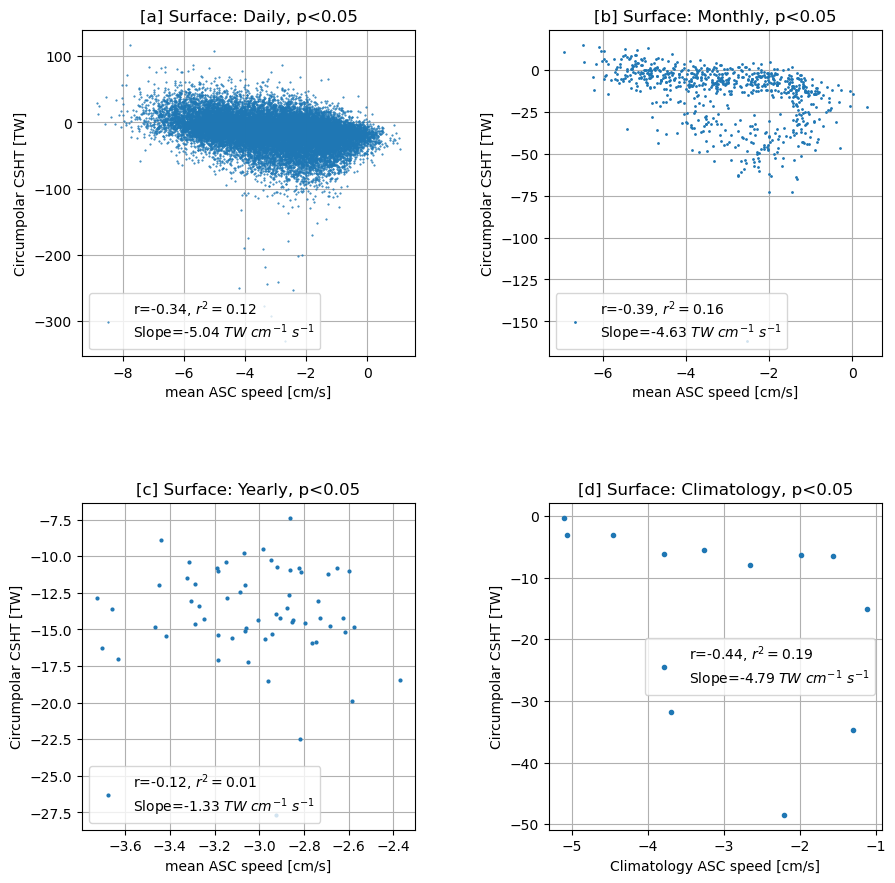

In [ ]:
plt.figure(figsize=(10, 10))
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.45)

#for panan01
plt.subplot(2,2,1)

slope_s, intercept_s, r_s, p_s, se_s = linregress(Ualong_surface,CSHTint_surface/1e12)
plt.plot(Ualong_surface*100,CSHTint_surface/1e12,'.',markersize=1,\
         label=r"r=" + str(round(r_s,2)) + ", $r^2=$" + str(round(r_s**2,2)) +\
            "\nSlope=" + str(round(slope_s*1e-2,2)) +  " $TW\ cm^{-1}\ s^{-1}$")
plt.xlabel('mean ASC speed [cm/s]'); plt.ylabel('Circumpolar CSHT [TW]')
plt.grid()
plt.title('[a] Surface: Daily, p<0.05')
plt.legend()


plt.subplot(2,2,2)
slopem_s, interceptm_s, rm_s, pm_s, sem_s = linregress(Ualong_surface.resample(time="1MS").mean('time'),(CSHTint_surface/1e12).resample(time="1MS").mean('time'))

plt.plot((Ualong_surface*100).resample(time="1MS").mean('time'),\
         CSHTint_surface.resample(time="1MS").mean('time')/1e12,'.',markersize=2,\
         label=r"r=" + str(round(rm_s,2)) + ", $r^2=$" + str(round(rm_s**2,2)) +\
            "\nSlope=" + str(round(slopem_s*1e-2,2)) +  " $TW\ cm^{-1}\ s^{-1}$")
plt.xlabel('mean ASC speed [cm/s]'); plt.ylabel('Circumpolar CSHT [TW]')
plt.grid()
plt.title('[b] Surface: Monthly, p<0.05')
plt.legend()


plt.subplot(2,2,3)

slopey_s, intercepty_s, ry_s, py_s, sey_s = linregress(Ualong_surface.resample(time="1Y").mean('time'),(CSHTint_surface/1e12).resample(time="1Y").mean('time'))

plt.plot((Ualong_surface*100).resample(time="1Y").mean('time'),\
         CSHTint_surface.resample(time="1y").mean('time')/1e12,'.',markersize=4,\
         label=r"r=" + str(round(ry_s,2)) + ", $r^2=$" + str(round(ry_s**2,2)) +\
            "\nSlope=" + str(round(slopey_s*1e-2,2)) +  " $TW\ cm^{-1}\ s^{-1}$")
plt.xlabel('mean ASC speed [cm/s]'); plt.ylabel('Circumpolar CSHT [TW]')
plt.grid()
plt.title('[c] Surface: Yearly, p<0.05')
plt.legend()


plt.subplot(2,2,4)

slopec_s, interceptc_s, rc_s, pc_s, sec_s = linregress(Ualong_surface.groupby('time.month').mean('time'),(CSHTint_surface/1e12).groupby('time.month').mean('time'))

plt.plot((Ualong_surface*100).groupby('time.month').mean('time'),\
         CSHTint_surface.groupby('time.month').mean('time')/1e12,'.',markersize=6,\
         label=r"r=" + str(round(rc_s,2)) + ", $r^2=$" + str(round(rc_s**2,2)) +\
            "\nSlope=" + str(round(slopec_s*1e-2,2)) +  " $TW\ cm^{-1}\ s^{-1}$")
plt.xlabel('Climatology ASC speed [cm/s]'); plt.ylabel('Circumpolar CSHT [TW]')
plt.grid()
plt.title('[d] Surface: Climatology, p<0.05')
plt.legend()

In all cases, the Surface regime presents lower correlations and slopes

##### Reverse regime

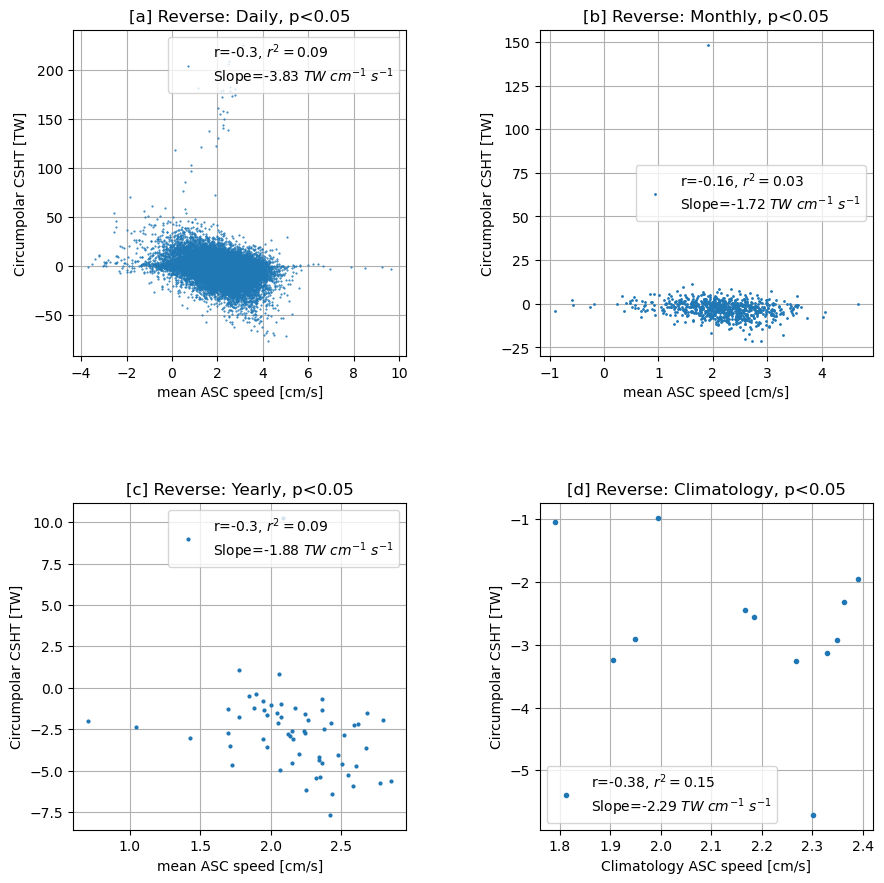

In [ ]:
plt.figure(figsize=(10, 10))
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.45)

#for panan01
plt.subplot(2,2,1)

slope_r, intercept_r, r_r, p_r, se_r = linregress(Ualong_reverse,CSHTint_reverse/1e12)
plt.plot(Ualong_reverse*100,CSHTint_reverse/1e12,'.',markersize=1,\
         label=r"r=" + str(round(r_r,2)) + ", $r^2=$" + str(round(r_r**2,2)) +\
            "\nSlope=" + str(round(slope_r*1e-2,2)) +  " $TW\ cm^{-1}\ s^{-1}$")
plt.xlabel('mean ASC speed [cm/s]'); plt.ylabel('Circumpolar CSHT [TW]')
plt.grid()
plt.title('[a] Reverse: Daily, p<0.05')
plt.legend()


plt.subplot(2,2,2)
slopem_r, interceptm_r, rm_r, pm_r, sem_r = linregress(Ualong_reverse.resample(time="1MS").mean('time'),(CSHTint_reverse/1e12).resample(time="1MS").mean('time'))

plt.plot((Ualong_reverse*100).resample(time="1MS").mean('time'),\
         CSHTint_reverse.resample(time="1MS").mean('time')/1e12,'.',markersize=2,\
         label=r"r=" + str(round(rm_r,2)) + ", $r^2=$" + str(round(rm_r**2,2)) +\
            "\nSlope=" + str(round(slopem_r*1e-2,2)) +  " $TW\ cm^{-1}\ s^{-1}$")
plt.xlabel('mean ASC speed [cm/s]'); plt.ylabel('Circumpolar CSHT [TW]')
plt.grid()
plt.title('[b] Reverse: Monthly, p<0.05')
plt.legend()


plt.subplot(2,2,3)

slopey_r, intercepty_r, ry_r, py_r, sey_r = linregress(Ualong_reverse.resample(time="1Y").mean('time'),(CSHTint_reverse/1e12).resample(time="1Y").mean('time'))

plt.plot((Ualong_reverse*100).resample(time="1Y").mean('time'),\
         CSHTint_reverse.resample(time="1y").mean('time')/1e12,'.',markersize=4,\
         label=r"r=" + str(round(ry_r,2)) + ", $r^2=$" + str(round(ry_r**2,2)) +\
            "\nSlope=" + str(round(slopey_r*1e-2,2)) +  " $TW\ cm^{-1}\ s^{-1}$")
plt.xlabel('mean ASC speed [cm/s]'); plt.ylabel('Circumpolar CSHT [TW]')
plt.grid()
plt.title('[c] Reverse: Yearly, p<0.05')
plt.legend()


plt.subplot(2,2,4)

slopec_r, interceptc_r, rc_r, pc_r, sec_r = linregress(Ualong_reverse.groupby('time.month').mean('time'),(CSHTint_reverse/1e12).groupby('time.month').mean('time'))

plt.plot((Ualong_reverse*100).groupby('time.month').mean('time'),\
         CSHTint_reverse.groupby('time.month').mean('time')/1e12,'.',markersize=6,\
         label=r"r=" + str(round(rc_r,2)) + ", $r^2=$" + str(round(rc_r**2,2)) +\
            "\nSlope=" + str(round(slopec_r*1e-2,2)) +  " $TW\ cm^{-1}\ s^{-1}$")
plt.xlabel('Climatology ASC speed [cm/s]'); plt.ylabel('Circumpolar CSHT [TW]')
plt.grid()
plt.title('[d] Reverse: Climatology, p<0.05')
plt.legend()

##### Deep regime

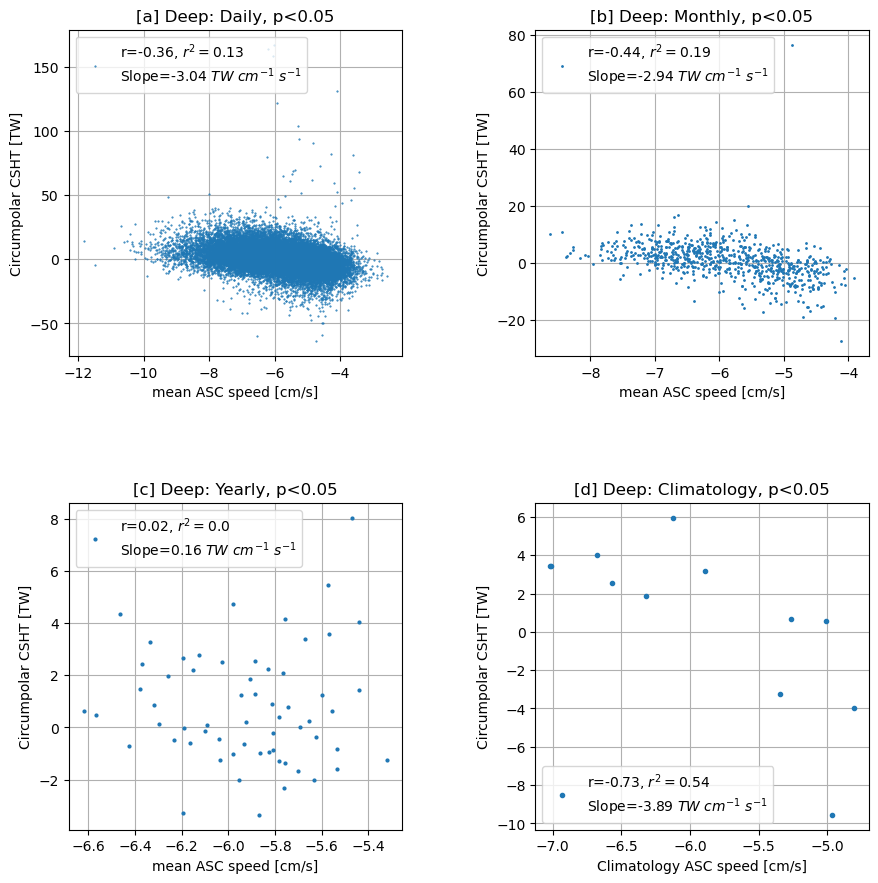

In [ ]:
plt.figure(figsize=(10, 10))
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.45)

#for panan01
plt.subplot(2,2,1)

slope_d, intercept_d, r_d, p_d, se_d = linregress(Ualong_deep,CSHTint_deep/1e12)
plt.plot(Ualong_deep*100,CSHTint_deep/1e12,'.',markersize=1,\
         label=r"r=" + str(round(r_d,2)) + ", $r^2=$" + str(round(r_d**2,2)) +\
            "\nSlope=" + str(round(slope_d*1e-2,2)) +  " $TW\ cm^{-1}\ s^{-1}$")
plt.xlabel('mean ASC speed [cm/s]'); plt.ylabel('Circumpolar CSHT [TW]')
plt.grid()
plt.title('[a] Deep: Daily, p<0.05')
plt.legend()


plt.subplot(2,2,2)
slopem_d, interceptm_d, rm_d, pm_d, sem_d = linregress(Ualong_deep.resample(time="1MS").mean('time'),(CSHTint_deep/1e12).resample(time="1MS").mean('time'))

plt.plot((Ualong_deep*100).resample(time="1MS").mean('time'),\
         CSHTint_deep.resample(time="1MS").mean('time')/1e12,'.',markersize=2,\
         label=r"r=" + str(round(rm_d,2)) + ", $r^2=$" + str(round(rm_d**2,2)) +\
            "\nSlope=" + str(round(slopem_d*1e-2,2)) +  " $TW\ cm^{-1}\ s^{-1}$")
plt.xlabel('mean ASC speed [cm/s]'); plt.ylabel('Circumpolar CSHT [TW]')
plt.grid()
plt.title('[b] Deep: Monthly, p<0.05')
plt.legend()


plt.subplot(2,2,3)

slopey_d, intercepty_d, ry_d, py_d, sey_d = linregress(Ualong_deep.resample(time="1Y").mean('time'),(CSHTint_deep/1e12).resample(time="1Y").mean('time'))

plt.plot((Ualong_deep*100).resample(time="1Y").mean('time'),\
         CSHTint_deep.resample(time="1y").mean('time')/1e12,'.',markersize=4,\
         label=r"r=" + str(round(ry_d,2)) + ", $r^2=$" + str(round(ry_d**2,2)) +\
            "\nSlope=" + str(round(slopey_d*1e-2,2)) +  " $TW\ cm^{-1}\ s^{-1}$")
plt.xlabel('mean ASC speed [cm/s]'); plt.ylabel('Circumpolar CSHT [TW]')
plt.grid()
plt.title('[c] Deep: Yearly, p<0.05')
plt.legend()


plt.subplot(2,2,4)

slopec_d, interceptc_d, rc_d, pc_d, sec_d = linregress(Ualong_deep.groupby('time.month').mean('time'),(CSHTint_deep/1e12).groupby('time.month').mean('time'))

plt.plot((Ualong_deep*100).groupby('time.month').mean('time'),\
         CSHTint_deep.groupby('time.month').mean('time')/1e12,'.',markersize=6,\
         label=r"r=" + str(round(rc_d,2)) + ", $r^2=$" + str(round(rc_d**2,2)) +\
            "\nSlope=" + str(round(slopec_d*1e-2,2)) +  " $TW\ cm^{-1}\ s^{-1}$")
plt.xlabel('Climatology ASC speed [cm/s]'); plt.ylabel('Circumpolar CSHT [TW]')
plt.grid()
plt.title('[d] Deep: Climatology, p<0.05')
plt.legend()

HEre we have some result that is more interesing. It seems that the majority of the correlation between the CSHT and ASC speed happens in the Deep regime, an it is due to the climatology (d). Here the correlation coefficient is the highest, and 54% of the CSHT variations in the regions of deep regime are explained by the ASC variability. That being said, we have some interesting things to keep in mind:

**1-Process**: Regions of ASC with Deep regime form DSW, a process that causes warm CDWs to enter the shelf (i.e., Morrison et al 2020). So the high control here doesnt mean that ASC seasonal variations acts as a barrier to CSHT, but likely means that as DSW forms, the Density stratification changes and CDW is likely invited into the shelf.

**2-Magintude**: The magnitude of CSHT variation in d is at least 1 order of maginitude smaller than the total variations seen in the CSHT in the fig 1.a. So this high correlation tells only a small aprt of the story

### Resolutions matter?

Although our model is still very high resolution, it likely still doesnt fully solve the eddy field along the ASC, which is at very high latitude. Do we think the figure a can change with resolution? lets calculate the CSHT in panan with different resolutions

In [ ]:
########  PANAN01 
# Load the along-slope velocity field
P01_u = xr.open_mfdataset('/home/156/wf4500/v45_wf4500/Project_panan/GH/Panan_HT_ASC/Processed_data/panan01/ASC_speed/daily_z/*')
# Load CSHT field
P01_HT = xr.open_mfdataset(\
    '/home/156/wf4500/v45_wf4500/Project_panan/GH/Panan_HT_ASC/Processed_data/panan01/CSHT_daily_z/*').rename({'zl':'z_l'})
P01_lon_along_contour=P01_HT.lon_along_contour.isel(time=0).drop('time').compute()
P01_lat_along_contour=P01_HT.lat_along_contour.isel(time=0).drop('time').compute()
P01_lon_bin_midpoints = P01_HT.lon_bin_midpoints.compute()
P01_lat_bin_midpoints = P01_HT.lat_bin_midpoints.isel(time=0).drop('time').compute()
P01_factor = float((P01_HT.unbinned_heat_transp_across_contour.mean('time').sum())/\
    ((P01_HT.binned_cross_slope_heat_trans + P01_HT.zonal_convergence).mean('time').sum()))
P01_HTub=P01_HT.unbinned_heat_transp_across_contour.compute()
P01_HT=((P01_HT.binned_cross_slope_heat_trans + P01_HT.zonal_convergence)*P01_factor).compute()

########  PANAN005
# Load the along-slope velocity field
P005_u = xr.open_mfdataset('/home/156/wf4500/v45_wf4500/Project_panan/GH/Panan_HT_ASC/Processed_data/panan005/ASC_speed/daily_z/*')
# Load CSHT field
P005_HT = xr.open_mfdataset(\
    '/home/156/wf4500/v45_wf4500/Project_panan/GH/Panan_HT_ASC/Processed_data/panan005/CSHT_daily_z/*').rename({'zl':'z_l'})
P005_lon_along_contour=P005_HT.lon_along_contour.isel(time=0).drop('time').compute()
P005_lat_along_contour=P005_HT.lat_along_contour.isel(time=0).drop('time').compute()
P005_lon_bin_midpoints = P005_HT.lon_bin_midpoints.compute()
P005_lat_bin_midpoints = P005_HT.lat_bin_midpoints.isel(time=0).drop('time').compute()
P005_factor = float((P005_HT.unbinned_heat_transp_across_contour.mean('time').sum())/\
    ((P005_HT.binned_cross_slope_heat_trans + P005_HT.zonal_convergence).mean('time').sum()))
P005_HTub=P005_HT.unbinned_heat_transp_across_contour.compute()
P005_HT=((P005_HT.binned_cross_slope_heat_trans + P005_HT.zonal_convergence)*P005_factor).compute()


In [ ]:
# importing area and volume for averaging
exp01 = 'panant-01-zstar-ACCESSyr2'
exp005 = 'panant-005-zstar-ACCESSyr2'
start_time= '2000-01-01'
end_time= '2000-12-31'


######## Panana01
P01_vol= cc.querying.getvar(exp01, 'volcello', session,ncfile='%daily_z%',start_time=start_time,end_time=end_time).mean('time').sel(yh=lat_range)
P01_area =cc.querying.getvar(exp01, 'areacello', session,n=1).sel(yh=lat_range)
P01_dzt=P01_vol/P01_area

#and along the contour they should be
P01_dztmean=P01_dzt.sel(xh=P01_lon_along_contour,yh=P01_lat_along_contour,method='nearest').compute()
P01_area_along = P01_area.sel(xh=P01_lon_along_contour,yh=P01_lat_along_contour,method='nearest').compute()



######## Panana005
P005_vol= cc.querying.getvar(exp005, 'volcello', session,ncfile='%month_z%',start_time=start_time,end_time=end_time).mean('time').sel(yh=lat_range)
P005_area =cc.querying.getvar(exp005, 'areacello', session,n=1).sel(yh=lat_range)
P005_dzt=P005_vol/P005_area

#and along the contour they should be
P005_dztmean=P005_dzt.sel(xh=P005_lon_along_contour,yh=P005_lat_along_contour,method='nearest').compute()
P005_area_along = P005_area.sel(xh=P005_lon_along_contour,yh=P005_lat_along_contour,method='nearest').compute()


In [ ]:
######### Panan01
#mean heat transport
P01_CSHTint = (P01_HTub).sum('z_l').sum('contour_index')
P01_Umean= P01_u.u_along_contour.weighted(P01_dztmean.fillna(0)).mean('z_l').weighted(P01_area_along).mean('contour_index').compute()

######### Panan005
#mean heat transport
P005_CSHTint = (P005_HTub).sum('z_l').sum('contour_index')
P005_Umean= P005_u.u_along_contour.weighted(P005_dztmean.fillna(0)).mean('z_l').weighted(P005_area_along).mean('contour_index').compute()



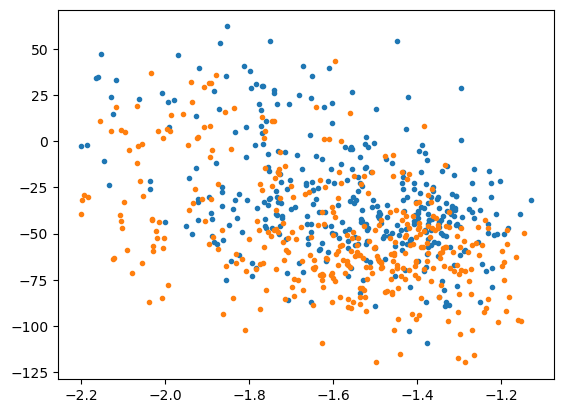

In [ ]:
plt.plot(P01_Umean*100,P01_CSHTint/1e12,'.',label='0.1')
plt.plot(P005_Umean*100,P005_CSHTint/1e12,'.',label='0.05')

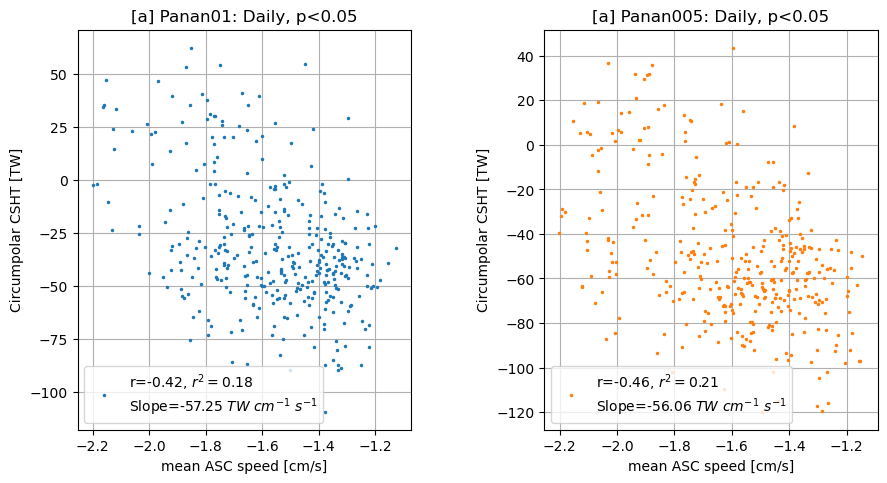

In [ ]:
plt.figure(figsize=(10, 5))
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.45)

#for panan01
P01slope, P01intercept, P01r, P01p, P01se = linregress(P01_Umean,P01_CSHTint/1e12)
plt.subplot(1,2,1)

plt.plot(P01_Umean*100,P01_CSHTint/1e12,'.',markersize=3,\
         label=r"r=" + str(round(P01r,2)) + ", $r^2=$" + str(round(P01r**2,2)) +\
            "\nSlope=" + str(round(P01slope*1e-2,2)) +  " $TW\ cm^{-1}\ s^{-1}$")
plt.xlabel('mean ASC speed [cm/s]'); plt.ylabel('Circumpolar CSHT [TW]')
plt.grid()
plt.title('[a] Panan01: Daily, p<0.05')
plt.legend()


#for panan005

P005slope, P005intercept, P005r, P005p, P005se = linregress(P005_Umean,P005_CSHTint/1e12)
plt.subplot(1,2,2)

plt.plot(P005_Umean*100,P005_CSHTint/1e12,'.',markersize=3,color='tab:orange',\
         label=r"r=" + str(round(P005r,2)) + ", $r^2=$" + str(round(P005r**2,2)) +\
            "\nSlope=" + str(round(P005slope*1e-2,2)) +  " $TW\ cm^{-1}\ s^{-1}$")
plt.xlabel('mean ASC speed [cm/s]'); plt.ylabel('Circumpolar CSHT [TW]')
plt.grid()
plt.title('[a] Panan005: Daily, p<0.05')
plt.legend()
